# Anomaly Detection via RandomCutForest

Mike Ames  
mikames@amazon.com  
13APR2022  


### Overview
-----

There are dozens (probably hundreds) of books dedicated to the subject of anomaly and outlier detection. The most common approaches expect that you know what “normal” looks like so that you can identify instances that don’t conform to the “normal” profile. There are statistical techniques, supervised, unsupervised, even semi-supervised methods to look at anomalies in data. This notebook uses Amazon SageMaker’s Random Cut Forest method to detect anomalous data points within a data set. RCF is an unsupervised algorithm which can be used to identify observations which diverge from otherwise well-structured data. 

RCF associates each data point with anomaly score. Low score values indicate that the data point is considered "normal." High values indicate the presence of an anomaly in the data. The definitions of "low" and "high" depend on the dataset as well see. 


### How to use this notebook 
-----
The goal of this notebook is to identify some number of anomalies in your data and use the RCF to create an EVENT_LABEL. In the event that you have some examples of fraud, great we'll perserve those if not we'll go ahead and gernate a EVENT_LABEL and assign a number of anomalies you can use as a target. 




#### Setup 
-----
To get started you need the following information 
1. location of your CSV file to train on. 
2. you'll need to fire up sagemaker and ensure that the sagemaker user is authorized to publish an endpiont 
3. location of where you want to write out your CSV file. 


<div class="alert alert-info"> <strong> Overview </strong>

- S3_BUCKET: this is the location you will be reading and writing from 
- S3_FILE_IN: this is the input file name you'll use to train your RCF on.   
- S3_FILE_OUT: this is the output file name you'll write your CSV file out with. 

</div>


In [1]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

# -- common stuff -- 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

# -- AWS stuff --- 
import boto3
import botocore
import sagemaker
import sys

role = sagemaker.get_execution_role()
# -- need this to render charts in notebook -- 
%matplotlib inline

## Your Dataset and Location 

---- 

My dataset happens to be located in a S3 bucket, yours could be local just change the read_csv to the appropraite location. All we are going to do here is read the file into a panda's dataframe. Then 

<div class="alert alert-info"> <strong> S3 </strong>
 
- S3_BUCKET : name of the bucket containing the file 
- S3_FILE_IN   : name of the file you will train your RCF with, often known as the file_ or data_key
- S3_FILE_OUT   : name of the file you will create with your new EVENT_LABEL
copy and paste the following if you are going this route: 

</div>

```python
S3_BUCKET = '2022-data'
S3_FILE_IN   = 'rcf_110k.csv'
S3_FILE_OUT   = 'rcf_110k_preparedcsv'
S3_LOCATION = 's3://{}/{}'.format(S3_BUCKET, S3_FILE_IN)
S3_LOCATION_OUT = 's3://{}/{}'.format(S3_BUCKET, S3_FILE_OUT)
print("input file location: {}".format(S3_LOCATION))
print("input file location: {}".format(S3_LOCATION_OUT))
df = pd.read_csv(S3_LOCATION)
df.head()

````


### Dataset Format 

Assuming we are using Amazon Fraud Detector, your file may or may not contain an EVENT_LABEL but should contain an EVENT_TIMESTAMP. We will be creating an EVENT_LABEL based on the RCF score below. IF you do have an EVENT_LABEL in the data we'll use this to evaluate how well the RCF performs on your sample data. 


In [2]:
S3_BUCKET = '2022-data'
S3_FILE_IN   = 'rcf_110k.csv'
S3_FILE_OUT   = 'rcf_110k_prepared.csv'
S3_LOCATION = 's3://{}/{}'.format(S3_BUCKET, S3_FILE_IN)
S3_LOCATION_OUT = 's3://{}/{}'.format(S3_BUCKET, S3_FILE_OUT)
print("input file location: {}".format(S3_LOCATION))
print("input file location: {}".format(S3_LOCATION_OUT))
df = pd.read_csv(S3_LOCATION)
df.head()


input file location: s3://2022-data/rcf_110k.csv
input file location: s3://2022-data/rcf_110k_prepared.csv


,account_tenure_yrs,normalized_currency_amt,original_currency_amt,currency,EVENT_TIMESTAMP,ip_address,email_address,EVENT_LABEL
0,11.0,38334.0,36466.0,eur,2021-08-14 05:38:58,57.115.15.248,lcarlson@example.org,legit
1,6.0,50104.0,24775.0,usd,2021-10-21 13:29:39,203.218.41.214,brianfowler@example.org,legit
2,16.0,21516.0,46364.0,usd,2021-06-18 03:28:47,131.7.35.71,lthomas@example.org,legit
3,6.0,50446.0,23668.0,usd,2021-05-08 22:44:29,150.245.11.96,victoria20@example.com,legit
4,10.0,43560.0,32309.0,eur,2021-08-24 00:17:08,155.110.112.38,amandamartinez@example.com,legit


## Profile the data. 
-----

The following function simply profiles your data frame and determines which variables shoudl be included and how they should be handled for the RCF.

In [3]:
def df_profile(df):
    
    df = df.copy()
    
    numeric_features = [ c for c in df.select_dtypes(include = np.number).columns ]
    
    categorical_features = [ c for c in df.select_dtypes(include = np.object).columns ]
   
    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique','mean','min','max']).transpose().reset_index().rename(columns={"index":"feature_name"}).round(4)
    df_s1['count'] = df_s1['count'].astype('int64')
    df_s1['nunique'] = df_s1['nunique'].astype('int64')
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique'] / rowcnt
    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner')

    df_stats = df_stats.sort_values("dtype").reset_index(drop=True)
    # -- part 2 
    df_stats['feature_type'] = "IGNORE"
    df_stats.loc[(df_stats["dtype"] == object) & (df_stats["nunique"] <= 32), 'feature_type'] = "CATEGORY"
    df_stats.loc[(df_stats["dtype"] == "int64") | (df_stats["dtype"] == "float64"), 'feature_type'] = "NUMERIC"
    # df_stats.loc[df_stats["dtype"] == "float64", 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats["feature_name"] == "EVENT_LABEL", 'feature_type'] = "TARGET"
    df_stats.loc[df_stats["feature_name"] == "EVENT_TIMESTAMP", 'feature_type'] = "EVENT_TIMESTAMP"
    
    
    # -- part 3 
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[df_stats["nunique_pct"] > 0.7,'feature_warning' ] = "EXCLUDE, GT 70% UNIQUE"
    df_stats.loc[(df_stats["null_pct"] > 0.2) & (df_stats["null_pct"] <= 0.5), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats["null_pct"] > 0.5,'feature_warning' ] = "EXCLUDE, GT 50% MISSING"
    #if null_pct > 0.2 then feature_warning = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
    #df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
    df_stats.loc[df_stats["feature_name"] == "EVENT_LABEL",'feature_warning' ] = "TARGET VARIABLE"
    return df_stats

df_stats = df_profile(df)
df_stats


,feature_name,dtype,count,nunique,mean,min,max,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
0,account_tenure_yrs,float64,110000,25,11.412,0,24,0,110000,0.0,0.000227,NUMERIC,NO WARNING
1,normalized_currency_amt,float64,110000,35468,41020.2,100,99999,0,110000,0.0,0.322436,NUMERIC,NO WARNING
2,original_currency_amt,float64,110000,49692,42961.1,100,99999,0,110000,0.0,0.451745,NUMERIC,NO WARNING
3,currency,object,110000,3,NaN,cad,usd,0,110000,0.0,0.000027,CATEGORY,NO WARNING
4,EVENT_TIMESTAMP,object,110000,109800,NaN,2021-04-13 03:45:59,2022-04-13 09:28:40,0,110000,0.0,0.998182,EVENT_TIMESTAMP,"EXCLUDE, GT 70% UNIQUE"
5,ip_address,object,110000,109999,NaN,1.1.25.108,99.94.90.205,0,110000,0.0,0.999991,IGNORE,"EXCLUDE, GT 70% UNIQUE"
6,email_address,object,110000,93435,NaN,aabbott@example.com,zzimmerman@example.com,0,110000,0.0,0.849409,IGNORE,"EXCLUDE, GT 70% UNIQUE"
7,EVENT_LABEL,object,110000,2,NaN,fraud,legit,0,110000,0.0,0.000018,TARGET,TARGET VARIABLE


## Data Transformation 
-----
RCF only works on numeric data so we are going to identify which variables we want to use based on the profile and how we'll handle nulls and categorical variables. You can ooptionally overwrite the selection.

- numeric variables with null values will be replaced with -1 
- categorical variables with null values will be replaced with "UNKNOWN"
- categorical variables will be dummy encoded for simplicy

> Note: only categories with fewer than 32 levels are included, there are of course several other transformations we could perform but this will get the ball rolling!

----
If you want to include or exclude varaibles in the detection simply specify the variable names in a list like this 

```python

numeric_features = ['account_tenure_yrs', 'normalized_currency_amt', 'original_currency_amt']
categorical_features = ['currency']

```

finally, we are going to check your file to see if it contains an EVENT label if it does pleas identity the "fraud" label, we'll perserve the frauds and use them to assess your RCF model

In [4]:
numeric_features = df_stats[df_stats["feature_type"] == "NUMERIC"]["feature_name"].tolist()
numeric_features

['account_tenure_yrs', 'normalized_currency_amt', 'original_currency_amt']

In [5]:
categorical_features = df_stats[df_stats["feature_type"] == "CATEGORY"]["feature_name"].tolist()
categorical_features

['currency']

In [6]:
event_label_ind = df_stats.query('feature_name == "EVENT_LABEL"').shape[0]
if event_label_ind == 0:
    print("your dataset doesn't contain a EVENT_LABEL, no problem this will create one for you")
if event_label_ind == 1:
    print("your dataset does contain EVENT_LABEL, we can perserve your labeled events below")

your dataset does contain EVENT_LABEL, we can perserve your labeled events below


In [7]:
# -- define your fraud label IF you have an EVENT_LABEL!
FRAUD_LABEL = "fraud"

## Prepare Data 

RandomCutForest only deals with numeric data that has no missing values, so we have to deal with missing values and have to dummy encode categories easy way to do this is using panda's get_dummies. 

---- 

```python
df = pd.get_dummies(df,columns=['currency'])
```

finally we are going to split the data into a training and test split. 

In [8]:
def prep_dataset(df):
    df = df.copy()
    df[numeric_features] = df[numeric_features].fillna(-1)
    df[categorical_features] = df[categorical_features].fillna("UNKNOWN")
   
    if event_label_ind == 0:
        df_prep = pd.get_dummies(df[numeric_features + categorical_features ], columns=categorical_features)
    if event_label_ind == 1:
        df_prep = pd.get_dummies(df[["EVENT_LABEL"] + numeric_features + categorical_features ], columns=categorical_features)

    return df_prep

df_prep = prep_dataset(df)
df_prep.head()

,EVENT_LABEL,account_tenure_yrs,normalized_currency_amt,original_currency_amt,currency_cad,currency_eur,currency_usd
0,legit,11.0,38334.0,36466.0,0,1,0
1,legit,6.0,50104.0,24775.0,0,0,1
2,legit,16.0,21516.0,46364.0,0,0,1
3,legit,6.0,50446.0,23668.0,0,0,1
4,legit,10.0,43560.0,32309.0,0,1,0


### Review training features
-----
Before kicking off training, lets double check our input features! 

you can override the feature selection using the following 

```python
training_features = ['account_tenure_yrs', 'normalized_currency_amt', 'original_currency_amt', 'currency_cad']

```


In [9]:
# this will set the input features for training. 
excluded_features = ["EVENT_LABEL","EVENT_TIMESTAMP"]
training_features  = [item for item in df_prep.columns if item not in excluded_features]
print("training input features: \n{}".format(training_features))

# feature count will give us the dimensionality of our numpy array. 
feature_count = df_prep.shape[1] - 1
print("number input features: {}".format(feature_count))

training input features: 
['account_tenure_yrs', 'normalized_currency_amt', 'original_currency_amt', 'currency_cad', 'currency_eur', 'currency_usd']
number input features: 6


### Write Training data to S3

---- 

here we are going to write our prepared data to S3

In [10]:

print("number of train instances : {} ".format(df_prep.shape[0] ))
# upload train and test to S3 
s3 = boto3.client("s3")
csv_buf = StringIO()
# -- write training data set to S3
train_key = 'rcf_train.csv'
df.to_csv(csv_buf, header=True, index=False)
csv_buf.seek(0)
resp = s3.put_object(Bucket=S3_BUCKET, Body=csv_buf.getvalue(), Key=train_key)
print("writing train to s3 bucket: {}".format(S3_BUCKET))
print("{}\n".format(resp))


number of train instances : 110000 
writing train to s3 bucket: 2022-data
{'ResponseMetadata': {'RequestId': '0CVGZ9RWZSSZ5WVE', 'HostId': '1Yfop3XoPjwliiPNKyHXWuF1/NVe3KLiy1gM1Jjkvro/LtIUwJbXnxpOM9Rjpylvg1U0TB5ktLc=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': '1Yfop3XoPjwliiPNKyHXWuF1/NVe3KLiy1gM1Jjkvro/LtIUwJbXnxpOM9Rjpylvg1U0TB5ktLc=', 'x-amz-request-id': '0CVGZ9RWZSSZ5WVE', 'date': 'Fri, 22 Apr 2022 16:10:30 GMT', 'etag': '"7ae319dfd63ec736ba62cbe94acd311a"', 'server': 'AmazonS3', 'content-length': '0'}, 'RetryAttempts': 0}, 'ETag': '"7ae319dfd63ec736ba62cbe94acd311a"'}



## Train your RandomCutForest 

The following will kick off a fit of RandomCutForest 
you can tinker with the following parameters 

num_samples_per_tree - this is the number of samples used to train each tree if there is little variation in the data 512 is fine, larger for more variation.  


- num_trees - number of randomly constructed trees. Increasing num_trees has the effect of reducing the noise observed in anomaly scores since the final score is the average of the scores reported by each tree. It is recommend to start with 100 trees as a balance between score noise and model complexity. 

- num_samples_per_tree - this is the number of samples used to train each tree. num_samples_per_tree is related to the '''expected density''' of anomalies in the dataset. In particular, num_samples_per_tree should be chosen such that 1/num_samples_per_tree approximates the ratio of anomalous data to normal data. For example, if 256 samples are used in each tree then we expect our data to contain anomalies 1/256 or approximately 0.4% of the time. Again, an optimal value for this hyperparameter is dependent on the application.


NOTE: RandomCutForest takes a numpy array as training data, so you'll want to convert to an array and reshape the array to number of records (-1) and width of numeric columns (3) for this dataset. if you add dummies for currency for example you'll have 3 currencies of 0s and 1s. 



In [11]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{S3_BUCKET}/",
    output_path=f"s3://{S3_BUCKET}/output",
    num_samples_per_tree=512,               # -- change 512, 1024 or some other fraction of file size 
    num_trees=100,                          # -- number of trees, more is generally good 50 - 1k is generally fine. 
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(df_prep[training_features].to_numpy().reshape(-1,feature_count)))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-04-22 16:10:31 Starting - Starting the training job...
2022-04-22 16:10:57 Starting - Preparing the instances for trainingProfilerReport-1650643831: InProgress
.........
2022-04-22 16:12:16 Downloading - Downloading input data...
2022-04-22 16:12:55 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/22/2022 16:13:45 INFO 139818605459264 integration.py:636] worker started
[04/22/2022 16:13:45 INFO 139818605459264] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[04/22/2022 16:13:45 INFO 139818605459264] Merging wit

In [12]:
# -- deploys model 
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
rcf_inference

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


--------!

In [13]:
# -- name of the endpiont 
print(f"Endpoint name: {rcf_inference.endpoint}")

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2022-04-22-16-14-45-973


In [14]:
# -- setup for predictions 
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

## Evaluate 

-----

So here we are going to score the dataset and evaluate a "suggested" outlier score threshold. this will ultimately be used to create our new "EVENT_LABEL" 

1. first score the entire dataset 
2. identify a "sugested outlier score threshold"  based on identifying the top 400 most anomalous events.  
3. Finally we'll look at the number of "anomalies" produced at the "sugested outlier_score threshold", you can simply increase or decrease the threshold to generate the number of anomalies.  

> Once you are satisfied with the sugested_threshold, it will be used to create your EVENT_LABEL.

you can override the sugestion by simply plugging in a new value for example
```python

RCF_ANOMALY_THRESHOLD = 3.0

```


In [15]:
# -- 1. score entire datset 
scored_data = df_prep[training_features].to_numpy().reshape(-1, feature_count)
results = rcf_inference.predict(scored_data)
scores = [datum["score"] for datum in results["scores"]]

# add scores to taxi data frame and print first few values
df_prep["outlier_score"] = pd.Series(scores, df_prep.index)
df_prep.head()

,EVENT_LABEL,account_tenure_yrs,normalized_currency_amt,original_currency_amt,currency_cad,currency_eur,currency_usd,outlier_score
0,legit,11.0,38334.0,36466.0,0,1,0,0.711910
1,legit,6.0,50104.0,24775.0,0,0,1,0.732559
2,legit,16.0,21516.0,46364.0,0,0,1,1.084913
3,legit,6.0,50446.0,23668.0,0,0,1,0.746878
4,legit,10.0,43560.0,32309.0,0,1,0,0.677090


In [16]:
# -- 2. sugested score threshold --- 
RCF_ANOMALY_THRESHOLD = df_prep.sort_values("outlier_score", ascending=False).iloc[400]["outlier_score"]
print("sugested outlier_score threshold {:.3f}".format(RCF_ANOMALY_THRESHOLD))

sugested outlier_score threshold 2.052


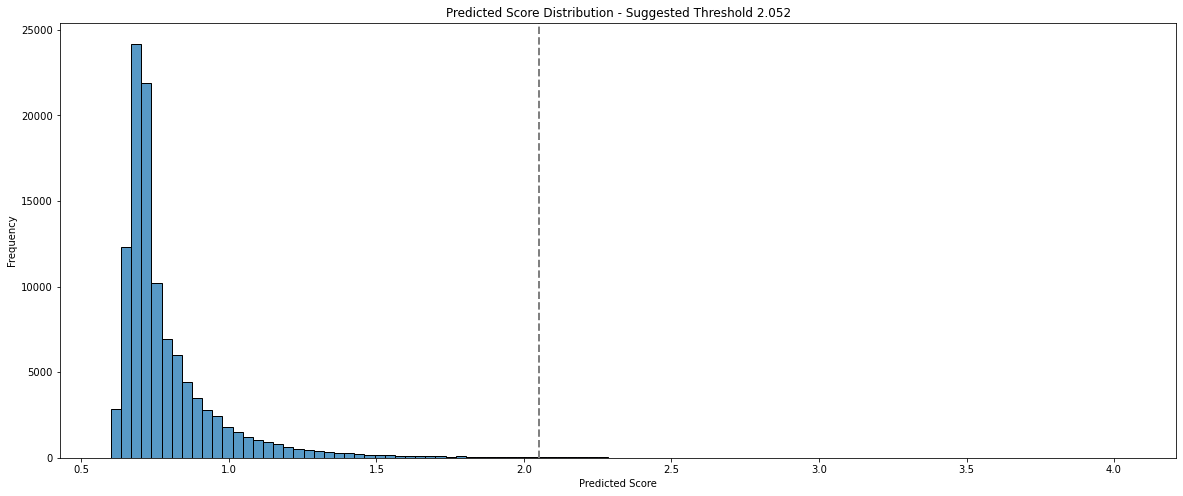

In [18]:
# 
plt.figure(figsize = (20,8))
sns.histplot(data=df_prep,x="outlier_score", bins=100)
plt.title("Predicted Score Distribution - Suggested Threshold {:.3f}".format(RCF_ANOMALY_THRESHOLD))
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.axvline(x=RCF_ANOMALY_THRESHOLD, ls='--', linewidth = 2, c='grey')


Original fraud labels + some overlapping number of Anomalies
legit    109766
fraud       234
Name: EVENT_LABEL, dtype: int64


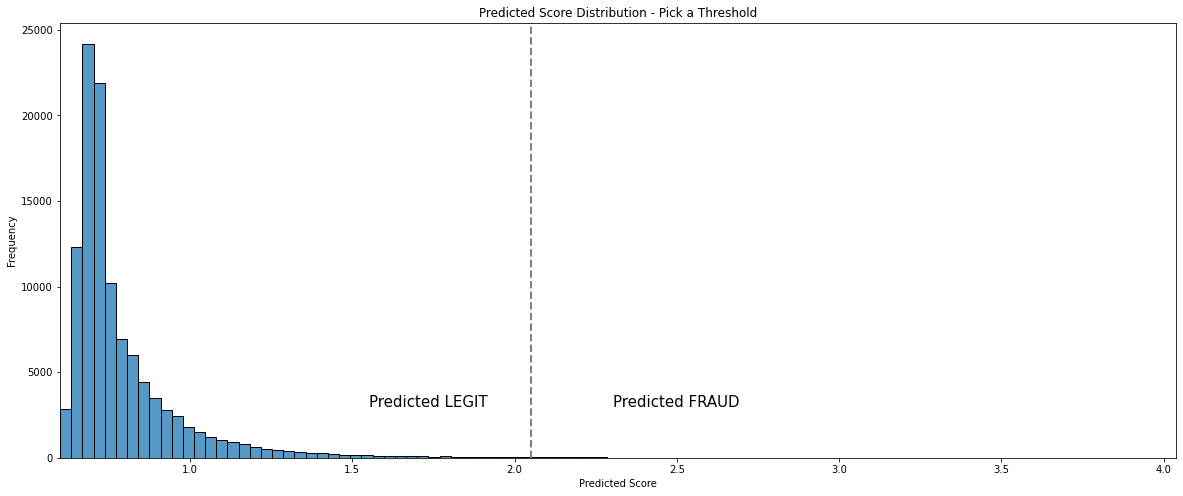

In [19]:
# -- pick a threshold here i use 2, docs often recomend 3 key is to identify enough variables to train a model 

if event_label_ind == 0:
    df_prep["EVENT_LABEL"]  = np.where(df_prep["outlier_score"] >= RCF_ANOMALY_THRESHOLD, "fraud","legit")
    print(df["EVENT_LABEL"].value_counts())

if event_label_ind == 1:
    df_prep["EVENT_LABEL"] = np.where((df_prep["outlier_score"] >= RCF_ANOMALY_THRESHOLD) & (df_prep["EVENT_LABEL"] != FRAUD_LABEL),"fraud","legit")
    print("Original fraud labels + some overlapping number of Anomalies")
    print(df_prep["EVENT_LABEL"].value_counts())    
    

plt.figure(figsize = (20,8))
sns.histplot(data=df_prep,x="outlier_score", bins=100, )
plt.title("Predicted Score Distribution - Pick a Threshold")
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.xlim(df_prep["outlier_score"].min(), df_prep["outlier_score"].max())
plt.text(x=RCF_ANOMALY_THRESHOLD - 0.5,y=3000,s="Predicted LEGIT", fontsize=15)
plt.text(x=RCF_ANOMALY_THRESHOLD + 0.25,y=3000,s="Predicted FRAUD", fontsize=15)
plt.axvline(x=RCF_ANOMALY_THRESHOLD, ls='--', linewidth = 2, c='grey')

## Write write out Dataset to S3
----
1. update/create an EVENT LABEL on the original input dataset. 
2. write data frame to S3. 
3. fire up AFD and train a new model 

In [20]:
# 2. drop 'outlier_score' and 'outlier_ind' from the dataset! 
df["EVENT_LABEL"] = df_prep["EVENT_LABEL"]
df.head()

,account_tenure_yrs,normalized_currency_amt,original_currency_amt,currency,EVENT_TIMESTAMP,ip_address,email_address,EVENT_LABEL
0,11.0,38334.0,36466.0,eur,2021-08-14 05:38:58,57.115.15.248,lcarlson@example.org,legit
1,6.0,50104.0,24775.0,usd,2021-10-21 13:29:39,203.218.41.214,brianfowler@example.org,legit
2,16.0,21516.0,46364.0,usd,2021-06-18 03:28:47,131.7.35.71,lthomas@example.org,legit
3,6.0,50446.0,23668.0,usd,2021-05-08 22:44:29,150.245.11.96,victoria20@example.com,legit
4,10.0,43560.0,32309.0,eur,2021-08-24 00:17:08,155.110.112.38,amandamartinez@example.com,legit


In [21]:
# upload train and test to S3 
s3 = boto3.client("s3")
csv_buf = StringIO()
# -- write training data set to S3
df.to_csv(csv_buf, header=True, index=False)
csv_buf.seek(0)
resp = s3.put_object(Bucket=S3_BUCKET, Body=csv_buf.getvalue(), Key=S3_FILE_OUT)
print("AFD ready file writen to :{}\n".format(S3_LOCATION_OUT))
print("{}\n".format(resp))

AFD ready file writen to :s3://2022-data/rcf_110k_prepared.csv

{'ResponseMetadata': {'RequestId': 'B4H2A20NH5Y5FAK2', 'HostId': 'ZihVrkEUExIo7Ij9XTVp0jzoAZmOYIFx9iLnE9v+FmesG3YofBTJ6qQ3ef7BEmoKMMXAgjqFvao=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'ZihVrkEUExIo7Ij9XTVp0jzoAZmOYIFx9iLnE9v+FmesG3YofBTJ6qQ3ef7BEmoKMMXAgjqFvao=', 'x-amz-request-id': 'B4H2A20NH5Y5FAK2', 'date': 'Fri, 22 Apr 2022 16:21:38 GMT', 'etag': '"7230128d0b3df818ae5b509ab9adbad6"', 'server': 'AmazonS3', 'content-length': '0'}, 'RetryAttempts': 0}, 'ETag': '"7230128d0b3df818ae5b509ab9adbad6"'}

